
**Name:** Shanmukh Adepu

**Uplevel Email Address:** adepushanmukh@gmail.com

**Business Problem:** 

The healthcare industry has witnessed a significant transformation with the integration of Artificial Intelligence (AI), Machine Learning (ML), and Deep Learning (DL). These advancements have enabled AI-driven diagnostics, patient monitoring, and intelligent symptom analysis.

However, despite the abundance of medical information, individuals often struggle to accurately interpret their symptoms and determine whether professional medical attention is necessary. The increasing reliance on online symptom checkers and self-diagnosis tools presents a challenge: ensuring accuracy, relevance, and efficiency in symptom analysis and disease prediction.

This project introduces MediBot, an AI-powered Symptom Checker that leverages advanced Natural Language Processing (NLP), Retrieval-Augmented Generation (RAG), and Multi-Agent AI to provide users with an interactive, intelligent, and context-aware medical assistant.

By automating preliminary medical consultations, MediBot enhances accessibility, reduces misinformation, and encourages early detection of potential health issues.

**Use Cases:** 

Medibot should be able to:
- Providing probable disease predictions based on symptom inputs.
- Offer symptom severity analysis to guide users on urgency.
- Explain diseases in a simplified manner.
- Suggest preventive measures and self-care recommendations.

**Scope:**

Symptom Check Functionality:
    - Focus on text-based symptom inputs, allowing users to describe their symptoms in natural language.
    - Provide immediate, context-aware responses regarding possible diseases, symptom severity, and self-care recommendations.
Multi-Agent System Functionality:
- Disease Diagnosis Agent:
    - Predicts probable illnesses
- Symptom Severity Checker:
    - Assesses how urgent and how the symptoms are  
- Disease Description Agent:
    - Explains conditions in a simplified manner
- Precaution Advisor Agent:
    - Offers preventative and self-care measures
Data & Retreival:
- Use FAISS for vector-based retrieval of relevant medical information
Conversational Memory:
- Maintain context across multiple user interactions to track symptom progression

**Limitations in Existing Models**

- Most models can only handle single-turn interactions
- Many symptom checkers rely on keyword matching
- Many models only have one agent as well
- Many responses do not account for individual medical history


In [1]:
# Importing the OpenAI library to interact with OpenAI's API services.
from openai import OpenAI

# Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langchain_text_splitters import RecursiveCharacterTextSplitter
import regex as re
import numpy as np
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
import gradio as gr
from langchain_core.tools import tool
from langchain.tools.render import render_text_description
from langchain_core.output_parsers import JsonOutputParser
import json
import getpass  # Importing getpass to securely input sensitive information

c:\Users\Rajendra\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**DataSets**

In total there are four datasets to review:
- Disease and Symptom matching dataset
- Symptom description dataset
- Symptom precaution dataset
- Symptom severity dataset


In [2]:
disease_symptom_df = pd.read_csv('./Medibot/dataset.csv')
disease_symptom_df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the above disease and symptom dataset, we can see that the dataset simply maps the multiple symptoms associated with each disease

In [3]:
disease_description_df = pd.read_csv('./Medibot/symptom_description.csv')
disease_description_df.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


Based on the above disease description database, it ca be seen that each disease has its own pre-defined description that we can store. 

In [4]:
disease_precaution_df = pd.read_csv('./Medibot/symptom_precaution.csv')
disease_precaution_df.head()

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


Based on the above disease precaution database it can be seen that each disease is mapped to a max set of 4 precautions. 

In [5]:
symptom_severity_df = pd.read_csv('./Medibot/Symptom-severity.csv')
symptom_severity_df.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


The above symptom severity database shows the weight of severity each symptom presents. 

**Data Analysis**


In [6]:
disease_symptom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


Based on the above data, it can be seen that the data representing the list of symptoms related to each disease, has a good amount of null values. However, this is simply due to the fact that some diseases have more symptoms than the rest. As a result, no changes to account for these null should be made. One change that needs to be done for easier integration down the line is changing each columns data type from an object to a string. 

In [7]:
disease_description_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Disease      41 non-null     object
 1   Description  41 non-null     object
dtypes: object(2)
memory usage: 788.0+ bytes


Based on the data surrounding the disease description dataset, it can be seen that no null values exist. However, the data types should be changed from objects to strings for down the line integration

In [8]:
disease_precaution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Disease       41 non-null     object
 1   Precaution_1  41 non-null     object
 2   Precaution_2  41 non-null     object
 3   Precaution_3  40 non-null     object
 4   Precaution_4  40 non-null     object
dtypes: object(5)
memory usage: 1.7+ KB


Now it can be noted that the dataset surrounding mapping a disease to a list of precautions only has one null value in two out of five rows. However, these rows are for the precautions that can be taken, and it is important to note that not all diseases have four precautions that can be taken. As a result, no change needs to be made down the line to accomodate for this. The datatypes should be changed from objects to strings for down the line integrations. 

In [9]:
symptom_severity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Symptom  133 non-null    object
 1   weight   133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


Based on the data surrounding the symptom severity rankings, it can be seen that no null values exist. However, the symptom column should be changed from object data types to string data types. 

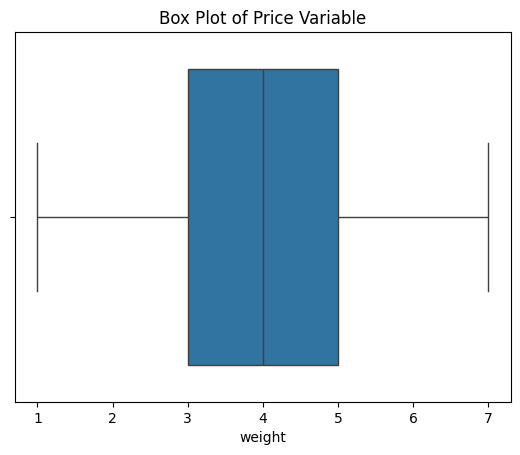

In [10]:
sns.boxplot(x=symptom_severity_df['weight'])
plt.title('Box Plot of Price Variable')
plt.show()

In [11]:
symptom_severity_df.describe()

,weight
count,133.000000
mean,4.225564
std,1.323543
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,7.000000


Based on the above data about the weight of each symptom, it can be seen that there are no outliers surrounding the weights. 

In [12]:
#Creates a list of columns including the title "Symptom" in their titles
symptom_cols = [col for col in disease_symptom_df.columns if 'Symptom' in col]

for col in symptom_cols:
    #Replace empty strings with NaN values
    disease_symptom_df[col] = disease_symptom_df[col].astype(str).str.strip().replace('', np.nan)
    
    #Replaces '_' with ' ' in symptom values
    disease_symptom_df[col] = disease_symptom_df[col].str.replace('_', ' ')

#Makes each disease value lowercase, strips whitespace, and converts it to a string
disease_symptom_df['Disease'] = disease_symptom_df['Disease'].astype(str).str.strip().str.lower()
disease_symptom_df

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,fungal infection,itching,skin rash,nodal skin eruptions,dischromic patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,fungal infection,skin rash,nodal skin eruptions,dischromic patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,fungal infection,itching,nodal skin eruptions,dischromic patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,fungal infection,itching,skin rash,dischromic patches,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,fungal infection,itching,skin rash,nodal skin eruptions,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) paroymsal positional vertigo,vomiting,headache,nausea,spinning movements,loss of balance,unsteadiness,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4916,acne,skin rash,pus filled pimples,blackheads,scurring,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4917,urinary tract infection,burning micturition,bladder discomfort,foul smell of urine,continuous feel of urine,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4918,psoriasis,skin rash,joint pain,skin peeling,silver like dusting,small dents in nails,inflammatory nails,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


I am altering the disease_symptom_df to make all diseases strings, and lowercase and getting rid of empty values with nan. 

In [13]:
# Standardize symptom names in severity dataset
symptom_severity_df['Symptom'] = symptom_severity_df['Symptom'].astype(str).str.strip().str.lower().str.replace('_', ' ')   
symptom_severity_df 

,Symptom,weight
0,itching,1
1,skin rash,3
2,nodal skin eruptions,4
3,continuous sneezing,4
4,shivering,5
...,...,...
128,inflammatory nails,2
129,blister,4
130,red sore around nose,2
131,yellow crust ooze,3


Above, I am going through the Symptom column in the symptom_severity_df dataframe and changing each symptom to a string, replacing '_' with a space, lowercasing the symptoms, and getting rid of whitespaces. 

In [14]:
# Flatten the values of all columns that contain symptom data into a single 1D array.
all_symptoms = disease_symptom_df[symptom_cols].values.flatten()

# Filter the flattened list to include only valid string entries.
all_symptoms = [s for s in all_symptoms if isinstance(s, str) and s.lower() != 'nan']
#Convert the list to a pandas Series and count the frequency of each symptom.
symptom_freq = pd.Series(all_symptoms).value_counts().reset_index()
symptom_freq.columns = ['Symptom', 'Frequency']

#Convert symptom names to lowercase and remove leading/trailing whitespace.
symptom_freq['Symptom'] = symptom_freq['Symptom'].str.strip().str.lower()
symptom_freq


,Symptom,Frequency
0,fatigue,1932
1,vomiting,1914
2,high fever,1362
3,loss of appetite,1152
4,nausea,1146
...,...,...
126,spotting urination,108
127,extra marital contacts,108
128,muscle wasting,108
129,patches in throat,108


The above code standardizes and aggregates symptom data from multiple columns, ensuring that variations in formatting or invalid entries don't skew the analysis. By cleaning and counting each symptom's occurrences, it provides a reliable summary that is crucial for accurate data exploration and decision-making.

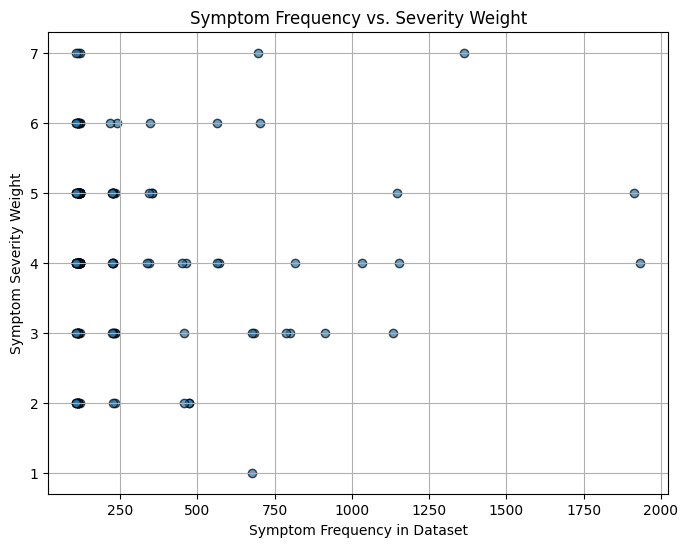

In [15]:
#Merge the symptom frequency DataFrame with the severity DataFrame on the 'Symptom' column.
df_merged = pd.merge(symptom_freq, symptom_severity_df, on='Symptom', how='left')

plt.figure(figsize=(8, 6))
plt.scatter(df_merged['Frequency'], df_merged['weight'], edgecolor='k', alpha=0.7)
plt.xlabel('Symptom Frequency in Dataset')
plt.ylabel('Symptom Severity Weight')
plt.title('Symptom Frequency vs. Severity Weight')
plt.grid(True)
plt.show()

Based on the above plot it can be seen that there is no strong linear relationship between how often a symptom appears in a dataset and its assigned severity weight. Therefore, high frequency symptoms can have both low and high severity weights, and vice versa. 

In [16]:
corr = df_merged['Frequency'].corr(df_merged['weight'])
print("Correlation between symptom frequency and severity weight:", corr)


Correlation between symptom frequency and severity weight: -0.011981241088206966


It can be seen that the correlation of around -0.012 indicates a near-zero linear relationship between symptom frequency and severity weight. This can be interpreted to mean that a symptoms frequency in a dataset is not predictive of its severity weight—common symptoms.

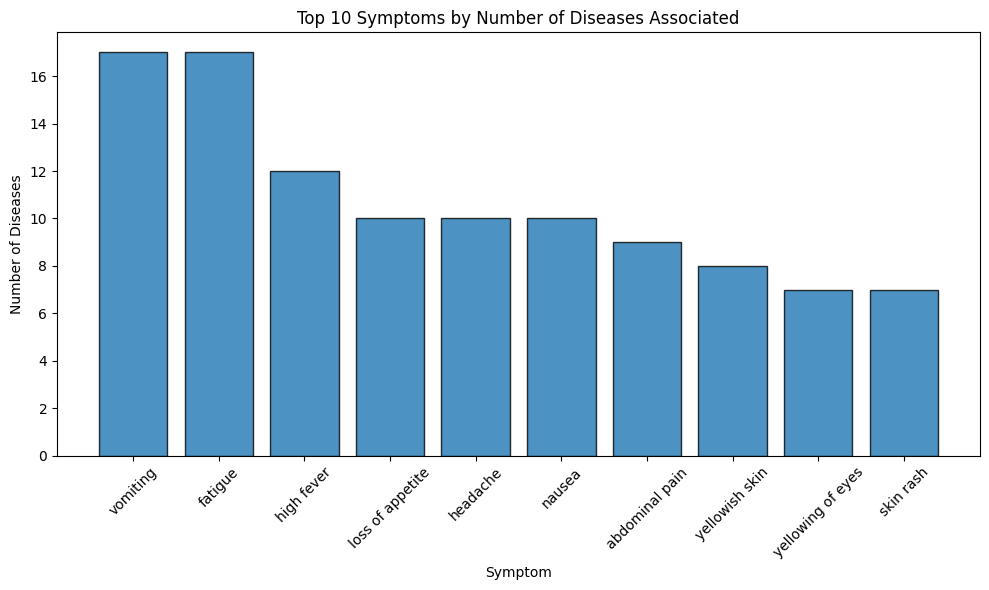

In [17]:
symptom_disease = {}
for _, row in disease_symptom_df.iterrows():
    disease = row['Disease']
    for col in symptom_cols:
        symptom = row[col]
        if pd.notna(symptom):
            symptom_clean = symptom.strip().lower()
            symptom_disease.setdefault(symptom_clean, set()).add(disease)

symptom_disease_count = pd.DataFrame({
    'Symptom': list(symptom_disease.keys()),
    'Disease Count': [len(diseases) for diseases in symptom_disease.values()]
}).sort_values(by='Disease Count', ascending=False)

symptom_disease_count = symptom_disease_count[symptom_disease_count['Symptom'] != 'nan']
top10 = symptom_disease_count.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10['Symptom'], top10['Disease Count'], edgecolor='k', alpha=0.8)
plt.xlabel('Symptom')
plt.ylabel('Number of Diseases')
plt.title('Top 10 Symptoms by Number of Diseases Associated')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Above, I am just trying to find the amount of diseases each symptom appears in. It is also sorted in descending order in order to visually see what symptoms appear the most. I am also dropping any 'nan' values since these are non-existing symptoms. 

**Implement FAISS**

In [18]:
#Getting the api key from a txt file
with open("./Medibot/api_key.txt", "r") as f:
    api_key = f.read().strip()
os.environ["OPENAI_API_KEY"] = api_key

#Creating a symptom knowledge base for the chatbot
symptom_knowledge_base = "\n".join(symptom_severity_df['Symptom'].dropna().unique())

#Creating a disease knowledge base for the chatbot
disease_knowledge_base = "\n".join(disease_description_df['Description'].dropna().unique())

# Initialize the text splitter to chunk knowledge bases.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

# Create documents from the knowledge bases.
symptom_documents = text_splitter.create_documents([symptom_knowledge_base])
disease_documents = text_splitter.create_documents([disease_knowledge_base])

# Create embeddings for the chunked documents.
embeddings = OpenAIEmbeddings()

# Create vector stores using FAISS for both symptom and disease documents.
symptom_vectorstore = FAISS.from_documents(symptom_documents, embeddings)
disease_vectorstore = FAISS.from_documents(disease_documents, embeddings)

# Initialize the ChatOpenAI model (adjust model name as needed).
llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], model='gpt-4o-mini')



Above, I am implementing FAISS by first creating documents of knowledge on symptoms and diseases. These documents also undergo a text splitter to chunk the data. I have also taken into account initializing the llm model that I plan on using down the line. 

In [19]:
def search_symptoms(query, symptom_vectorstore, disease_vectorstore, top_k=5):
    """
    Perform similarity search for symptoms and map them to diseases.
    
    Args:
        query (str): The user query (can be a single symptom or multi-symptom).
        symptom_vectorstore (FAISS): FAISS vector store for symptoms.
        disease_vectorstore (FAISS): FAISS vector store for diseases.
        top_k (int): Number of top results to retrieve.
    
    Returns:
        dict: Mapping of symptoms to a list of similar diseases.
    """
    # Generate embedding for the query.
    query_embedding = embeddings.embed_query(query)
    
    # Search for similar symptoms.
    symptom_results = symptom_vectorstore.similarity_search_by_vector(query_embedding, k=top_k)
    
    # Map each found symptom to diseases via a secondary search.
    symptom_to_disease_mapping = {}
    for result in symptom_results:
        symptom_text = result.page_content  # Extract the symptom text.
        disease_results = disease_vectorstore.similarity_search_by_vector(query_embedding, k=top_k)
        diseases = [disease.page_content for disease in disease_results]
        symptom_to_disease_mapping[symptom_text] = diseases
    return symptom_to_disease_mapping

def handle_query(query, symptom_vectorstore, disease_vectorstore):
    """
    Handle different query styles and return results.
    
    Args:
        query (str): The user query.
        symptom_vectorstore (FAISS): FAISS vector store for symptoms.
        disease_vectorstore (FAISS): FAISS vector store for diseases.
    
    Returns:
        dict: Results mapping symptoms to diseases.
    """
    if ',' in query:
        # Multi-symptom description.
        symptoms = [symptom.strip() for symptom in query.split(',')]
        results = {}
        for symptom in symptoms:
            results.update(search_symptoms(symptom, symptom_vectorstore, disease_vectorstore))
        return results
    else:
        # Single symptom or severity-based query.
        return search_symptoms(query, symptom_vectorstore, disease_vectorstore)
    
query = "skin rash, high fever"
results = handle_query(query, symptom_vectorstore, disease_vectorstore)
print("\nResults from FAISS-based similarity search:")
print(results)
for symptom, diseases in results.items():
    print(f"\nSymptom: {symptom}")
    print(f"Mapped Diseases: {', '.join(diseases)}")



Results from FAISS-based similarity search:
{'palpitations\npainful walking\npus filled pimples\nblackheads\nscurring\nskin peeling\nsilver like dusting\nsmall dents in nails\ninflammatory nails\nblister\nred sore around nose\nyellow crust ooze\nprognosis': ['Chickenpox is a highly contagious disease caused by the varicella-zoster virus (VZV). It can cause an itchy, blister-like rash. The rash first appears on the chest, back, and face, and then spreads over the entire body, causing between 250 and 500', "Psoriasis is a common skin disorder that forms thick, red, bumpy patches covered with silvery scales. They can pop up anywhere, but most appear on the scalp, elbows, knees, and lower back. Psoriasis can't be passed from person to person. It does", 'between 250 and 500 itchy blisters.', "Impetigo (im-puh-TIE-go) is a common and highly contagious skin infection that mainly affects infants and children. Impetigo usually appears as red sores on the face, especially around a child's nose 

Above, I am able to test FAISS-based similarity search for efficient disease retrieval based on symptoms provided by the user. 

**Agents**

In [20]:
@tool
def disease_diagnosis_agent(symptoms: list):
    """
    Predict probable diseases based on reported symptoms.
    Args:
        symptoms (list): List of symptom strings.
    Returns:
        dict: Diseases sorted by matching symptom counts.
    """
    user_symptoms = [s.strip().lower() for s in symptoms]
    scores = disease_symptom_df.set_index('Disease')[symptom_cols].apply(
        lambda x: x.str.lower().isin(user_symptoms).sum(),
        axis=1
    )
    return scores[scores > 0].sort_values(ascending=False).to_dict()

@tool
def symptom_severity_agent(symptoms: list):
    """
    Calculate overall severity from reported symptoms.
    Args:
        symptoms (list): List of symptom strings.
    Returns:
        float: Average severity score of symptoms.
    """
    severity_scores = symptom_severity_df[
        symptom_severity_df['Symptom'].isin(symptoms)
    ]['weight']
    return severity_scores.mean() if not severity_scores.empty else 0

@tool
def disease_description_agent(disease: str):
    """
    Retrieve a plain-language description of the disease.
    """
    desc = disease_description_df.loc[
        disease_description_df['Disease'].str.lower() == disease.lower(),
        'Description'
    ]
    return desc.values[0] if not desc.empty else "No description available."

@tool
def precaution_advisor_agent(disease: str):
    """
    Suggest precautionary measures for the disease.
    """
    precautions = disease_precaution_df.loc[
        disease_precaution_df['Disease'].str.lower() == disease.lower()
    ]
    return precautions.iloc[0, 1:].dropna().tolist() if not precautions.empty else []

tools = [
    disease_diagnosis_agent,
    symptom_severity_agent,
    disease_description_agent,
    precaution_advisor_agent
]
rendered_tools = render_text_description(tools)

Above I am creating agents that provide precautionary measures for the disease, retrieve a description of each disease, calculate symptom severity, and predict probable symptom diagnosises. 

**Gradio UI**

In [21]:
system_prompt = f"""
You are an AI medical assistant with access to the following tools:
{rendered_tools}

When given the conversation context and user input, return a JSON response
with the 'name' of the tool to use and the corresponding 'arguments'.
If multiple steps are needed, return a list of JSON objects sequentially.
If the query is invalid, contains typos, or is unsupported, return a JSON
object with a helpful error message.
"""

# 6. tool_chain to parse & invoke tools
def tool_chain(model_output):
    """
    The LLM must return either:
      - {"name": "...", "arguments": {...}} for single step
      - [{"name": "...","arguments": {...}}, ...] for multiple steps
      - {"error": "..."} if invalid
    """
    tool_map = {tool.name: tool for tool in tools}

    try:
        # If the LLM returned just a string (bad JSON or fallback)
        if isinstance(model_output, str):
            return {"result": model_output}

        # If it's a list -> multiple steps
        if isinstance(model_output, list):
            result = None
            for step in model_output:
                if not isinstance(step, dict) or "name" not in step or "arguments" not in step:
                    return {"result": "Sorry, I didn't understand your query."}
                tool_name = step["name"]
                args = step["arguments"]
                if tool_name not in tool_map:
                    return {"result": f"Unknown tool '{tool_name}' selected by AI."}
                result = tool_map[tool_name].invoke(args)
            return {"result": result}

        # If it's a single dict -> one step or an error object
        if isinstance(model_output, dict):
            if "error" in model_output:
                return {"result": model_output["error"]}

            if "name" not in model_output or "arguments" not in model_output:
                return {"result": "Sorry, I didn't understand your query."}
            tool_name = model_output["name"]
            args = model_output["arguments"]
            if tool_name not in tool_map:
                return {"result": f"Unknown tool '{tool_name}' selected by AI."}
            result = tool_map[tool_name].invoke(args)
            return {"result": result}

        return {"result": "Sorry, I didn't understand your query."}

    except Exception as e:
        return {"result": f"Error processing input: {str(e)}"}


# -------------- NEW: Build a dynamic prompt with history --------------
def build_chat_history_prompt(system_prompt_text, history, new_user_query):
    """
    Convert all prior user/assistant messages into a sequence of (role, content),
    plus the system prompt at the start, so the LLM sees the entire conversation.
    """
    # Start with system message
    messages = [("system", system_prompt_text)]

    # Then replay all previous user->assistant steps
    for user_text, assistant_text in history:
        messages.append(("user", user_text))
        messages.append(("assistant", assistant_text))

    # Finally, add the newest user query
    messages.append(("user", new_user_query))

    return ChatPromptTemplate.from_messages(messages)


# 7. The main function for Gradio
def medibot_response(query, history=None):
    if history is None:
        history = []

    try:
        # 1) Build a dynamic prompt from the entire conversation + new user query
        dynamic_prompt = build_chat_history_prompt(system_prompt, history, query)

        # 2) Create a local chain that uses the dynamic prompt
        local_chain = dynamic_prompt | llm | JsonOutputParser() | (lambda x: {"output": tool_chain(x)})

        # 3) Invoke the chain (the LLM sees all prior context)
        model_output = local_chain.invoke({})
        print("Raw LLM Output:", model_output)

        # 4) Extract the final tool result
        final_answer = model_output.get("output", {}).get("result", {})

        # 5) Summarize the tool result into bullet points (if a dict)
        if isinstance(final_answer, dict):
            result_text = "Possible diagnoses:\n"
            for disease, count in final_answer.items():
                result_text += f"- {disease.title()} (matching symptoms: {count})\n"
        else:
            result_text = str(final_answer)

        # 6) We do a second pass to the LLM to get a user-friendly final reply
        followup_prompt = f"""
        The user asked: "{query}"

        The tool-based analysis suggests:
        {result_text}

        Please provide a friendly, concise explanation of these findings,
        any recommended steps, and when the user should see a doctor.
        """
        final_llm_response = llm.invoke(followup_prompt)
        if hasattr(final_llm_response, "content"):
            final_llm_response = final_llm_response.content

        llm_response = final_llm_response.strip()

        # 7) Convert existing history to role/content for Gradio display
        converted_history = []
        for user_text, bot_text in history:
            converted_history.append({"role": "user", "content": user_text})
            converted_history.append({"role": "assistant", "content": bot_text})

        # 8) Append the new user query + final LLM summary
        converted_history.append({"role": "user", "content": query})
        converted_history.append({"role": "assistant", "content": llm_response})

        # 9) Also update `history` in (user, assistant) tuple format
        history.append((query, llm_response))

        return converted_history, history

    except Exception as e:
        error_message = f"Error: {str(e)}"
        print(error_message)

        # Return the error message in the chat
        converted_history = []
        for user_text, bot_text in history:
            converted_history.append({"role": "user", "content": user_text})
            converted_history.append({"role": "assistant", "content": bot_text})

        converted_history.append({"role": "assistant", "content": error_message})
        history.append((query, error_message))

        return converted_history, history

# 8. Build and launch Gradio Interface
demo = gr.Interface(
    fn=medibot_response,
    inputs=[
        gr.Textbox(placeholder="Describe your symptoms..."), 
        gr.State()
    ],
    outputs=[
        gr.Chatbot(type="messages"),  # uses openai-style messages
        gr.State()
    ],
    title="MediBot: AI-Powered Medical Assistant",
    description="Describe your symptoms to receive diagnosis, severity assessment, descriptions, and precautions."
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Raw LLM Output: {'output': {'result': {'chronic cholestasis': 1, 'hepatitis c': 1, 'malaria': 1, '(vertigo) paroymsal  positional vertigo': 1, 'hypoglycemia': 1, 'hepatitis e': 1, 'hepatitis d': 1, 'hepatitis a': 1, 'typhoid': 1, 'dengue': 1}}}


**System Architecture, Agent Interactions, and Setup Guide:** 

The system uses a Gradio interface for user input, which is passed to a central function that builds a conversation prompt and hands it to an LLM. The LLM decides which specialized agent tools (disease diagnosis, severity, description, and precautions) to invoke by returning a JSON object. These tools query dataframes containing disease-symptom relationships and other relevant information, then return results for final summarization. Setup involves installing the necessary Python libraries, placing CSV files for data, adding an OpenAI key in a text file, and running the script to launch the Gradio app locally.

**Detailed Inference Process Documentation for AI-driven Medical Assistance:** 

This project features a Gradio interface that captures user input about symptoms, compiles a conversation prompt, and hands it to a language model that decides which specialized agent tools—such as disease diagnosis, symptom severity, disease description, and precaution advisories—to invoke. Setup involves installing Python libraries, placing CSV files for data, including an OpenAI key, and running the script to launch the local Gradio app. The inference process merges conversation history, system prompts, and user queries, letting the model request tool-based data from local dataframes containing disease-symptom relationships, severity scores, and precaution measures. The final results are summarized by the language model and displayed in the chat.

**Submission Package:**

The codebase illustrates the entire flow—reading the CSV files, preprocessing data, setting up embeddings with a FAISS index, and orchestrating the conversation through Gradio and a ChatOpenAI-based LLM. The included CSVs provide mappings between diseases and symptoms, symptom severity scores, disease descriptions, and recommended precautions. In the technical report, the project’s goals, methodology, data preprocessing steps, and overall inference logic are explained in detail, which helps demonstrate how user queries flow from the UI to the LLM, down to the tool invocation layer, and ultimately back as a summarized response. The hosted link to this project is: https://huggingface.co/spaces/smoothadepu/MediBot_AI/tree/main.